<a href="https://colab.research.google.com/github/NKNU-VD/python-/blob/main/Text_to_Speech_0406.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FastSpeech2 語音合成
這份教學以 ming024 的 FastSpeech 2 實作，以及 seungwonpark 的 MelGAN vocoder 實作為基礎，來實作英文的語音合成。因為 ming024 原本實作的程式已更新，所以我們也參考了 MckinstryJ 的程式重新做調整。

這裡我們會使用作者 ming024 及 seungwonpark 預訓練好的模型來合成語音，只要透過簡單的套件將輸入的文句轉為 phoneme ，接著 FastSpeech 2 即會以 phoneme 為輸入來產生頻譜，而 MelGAN 則將頻譜再轉為聲音波型，就能得到可直接播放的語音了！



對理論感興趣的，可以參考以下論文：


*   [FastSpeech 2: Fast and High-Quality End-to-End Text-to-Speech](https://arxiv.org/abs/2006.04558v1)
*   [MelGAN: Generative Adversarial Networks for Conditional Waveform Synthesis
](https://arxiv.org/abs/1910.06711)


## 下載程式碼並安裝必要套件

In [18]:
import os
os.chdir("/content")

# 下載程式碼
!git clone https://github.com/MckinstryJ/FastSpeech2_LJSpeech.git
os.chdir("FastSpeech2_LJSpeech")
!git clone https://github.com/seungwonpark/melgan.git

# 安裝必要套件
!pip3 install -r requirements.txt
!pip3 install --pre torch==1.6.0


fatal: destination path 'FastSpeech2_LJSpeech' already exists and is not an empty directory.
fatal: destination path 'melgan' already exists and is not an empty directory.


## 下載預訓練模型

In [19]:
# 下載預訓練模型
ModelID = "1WKSkzzzBNf8bNi9fRZzbI57N8orSX6wP"
ModelPath = "FastSpeech.pth.tar"
!gdown --id {ModelID} -O {ModelPath}

Downloading...
From: https://drive.google.com/uc?id=1WKSkzzzBNf8bNi9fRZzbI57N8orSX6wP
To: /content/FastSpeech2_LJSpeech/FastSpeech.pth.tar
348MB [00:02, 154MB/s]


## 載入 FastSpeech 2 及 MelGAN 模型

In [20]:
import torch
import torch.nn as nn
from fastspeech2 import FastSpeech2
import hparams as hp
from melgan.model import generator

# 定義使用 GPU 或 CPU 運算
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 初始化 FastSpeech 2
model = nn.DataParallel(FastSpeech2())
# 載入預訓練參數
model.load_state_dict(torch.load(ModelPath, map_location=device)['model'])
# 將 model 設為評估狀態，因為這次教學中不做模型訓練，因此不需要計算 gradient
model.requires_grad = False
model.eval()
# 將 model 放進運算單元
model = model.to(device)

# 載入預訓練 MelGAN
if torch.cuda.is_available():
  melgan = torch.hub.load('seungwonpark/melgan', 'melgan')
else:
  # 如果使用 CPU 訓練，需要做額外的修改
  melgan = generator.Generator(hp.n_mel_channels)
  checkpoint = torch.hub.load_state_dict_from_url('https://github.com/seungwonpark/melgan/releases/download/v0.3-alpha/nvidia_tacotron2_LJ11_epoch6400.pt', map_location="cpu")
  melgan.load_state_dict(checkpoint["model_g"])
  melgan.eval(inference=True)

# 將 melgan 放進運算單元
melgan = melgan.to(device)

## 將輸入文句轉為 phoneme

In [21]:
import re
from string import punctuation
import numpy as np
from g2p_en import G2p
from text import text_to_sequence

# 將英文文句轉為 phoneme ，接著再轉為對應的 ID ，才能輸入 model
def preprocess(text):
    text = text.rstrip(punctuation)

    g2p = G2p()
    phoneme = g2p(text)
    phoneme = list(filter(lambda p: p != ' ', phoneme))
    print("原本的phoneme",phoneme)

    phoneme = '{'+ '}{'.join(phoneme) + '}'
    #phoneme = re.sub(r'\{[^\w\s]?\}', '{sp}', phoneme)
    phoneme = phoneme.replace('}{', ' ') 
    print('Phoneme sequence: {}'.format(' '.join(phoneme)))

    id_sequence = np.array(text_to_sequence(phoneme, hp.text_cleaners))
    id_sequence = np.stack([id_sequence])
    print('Phoneme ID sequence: {}'.format(' '.join([str(s) for s in id_sequence])))

    return torch.from_numpy(id_sequence).long().to(device)

sentence = "May the force be with you."
print('Input text:',sentence)
id_sequence = preprocess(sentence)
print(type(id_sequence))

Input text: May the force be with you.
原本的phoneme ['M', 'EY1', 'DH', 'AH0', 'F', 'AO1', 'R', 'S', 'B', 'IY1', 'W', 'IH1', 'DH', 'Y', 'UW1']
Phoneme sequence: { M   E Y 1   D H   A H 0   F   A O 1   R   S   B   I Y 1   W   I H 1   D H   Y   U W 1 }
Phoneme ID sequence: [118 102  91  73 104  78 130 131  88 113 144 109  91 145 141]
<class 'torch.Tensor'>


## 將 phoneme 輸入模型產生音檔

tensor([[-7.2307, -6.4473, -6.6924,  ..., -6.3396, -7.0642, -7.0981],
        [-6.5791, -5.8249, -5.7549,  ..., -5.9303, -6.4269, -6.5195],
        [-5.8391, -5.0665, -4.8356,  ..., -5.1334, -5.6230, -5.8389],
        ...,
        [-9.9558, -9.7892, -9.5524,  ..., -9.2940, -9.4142, -9.3844],
        [-9.8885, -9.7061, -9.4339,  ..., -9.2598, -9.4110, -9.3535],
        [-9.8455, -9.6852, -9.3832,  ..., -9.2098, -9.3849, -9.3248]])
<class 'torch.Tensor'>


[  5  -4 -16 ...  -9 -10  -3]
<class 'numpy.ndarray'>


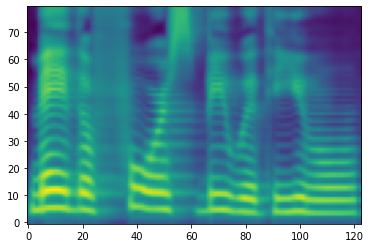

In [22]:
%matplotlib inline
import IPython.display as ipd
import matplotlib.pyplot as plt

def synthesize(id_sequence):
  # phoneme ID sequence 的長度
  src_len = torch.from_numpy(np.array([id_sequence.shape[1]])).to(device)

  with torch.no_grad():
    # 用 FastSpeech 2 產生 mel-spectrogram
    _, mel, _, _, _, _, _, mel_len = model(id_sequence, src_len)

    mel_torch = mel.transpose(1, 2)
    mel = mel[0].cpu().transpose(0, 1)

    # 用 MelGAN 產生聲音波型
    wav = melgan.inference(mel_torch).cpu().numpy()
    wav = wav.astype('int16')

  return mel, wav

# 產生頻譜以及聲音波型
mel, wav = synthesize(id_sequence)  
print(mel)
print(type(mel))
ipd.display(ipd.Audio(wav, rate=hp.sampling_rate))
print(wav)
print(type(wav))
ax = plt.imshow(mel, origin='lower')

## 自己嘗試看看!

Input text: Why I can't use Chinese!
原本的phoneme ['W', 'AY1', 'AY1', 'K', 'AE1', 'N', 'T', 'Y', 'UW1', 'S', 'CH', 'AY0', 'N', 'IY1', 'Z']
Phoneme sequence: { W   A Y 1   A Y 1   K   A E 1   N   T   Y   U W 1   S   C H   A Y 0   N   I Y 1   Z }
Phoneme ID sequence: [144  86  86 116  70 119 133 145 141 131  89  85 119 113 146]


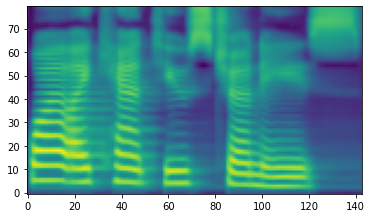

In [24]:
# 宣告sentence
sentence = "Why I can't use Chinese!"
# print你輸入的sentence 
print('Input text:',sentence)
# 宣告id_sequence 呼叫preprocess(把sentence作為參數傳入)
id_sequence = preprocess(sentence)
# 宣告mel和wav 呼叫synthesize(把phoneme的ID sequence作為參數傳入)
mel, wav = synthesize(id_sequence)
# 輸出文字轉語音結果
ipd.display(ipd.Audio(wav, rate=hp.sampling_rate))
# 用plt把頻譜畫出來
ax = plt.imshow(mel, origin='lower')